In [53]:
# -*- coding: utf-8 -*-
#  File: main.ipynb
#  Project: 'OTUS.PRO Homework #5'
#  Created by Gennady Matveev (gm@og.ly) on 22-05-2022.

<IPython.core.display.Javascript object>

# **$Homework$** **$5$**  
**OTUS Machine Learning Professional**

### Parsing and NLP

![Parsing and NLP](https://docs.google.com/uc?export=download&id=10d8UpDr67Ib2_GdlzCK2xVyuVrpNevsh)

**Goals:**  
1. Parse archive of Medium "Towards data science" publications:
- Parsed article's data are:
    - url
    - author, 
    - title
    - subtitle
    - claps (likes)
    - responses (comments)
    - reading time
    - publication date
2. NLP 
- Split data into train and test sets;
- Apply TF-IDF to text data (title+subtitle);
- Build regression model with claps as target and visualize results.

**Additional goals:**  

- Perform EDA to check dependencies between parsed features. Use [binsreg](https://github.com/nppackages/binsreg) estimations.
- Have a look at [Texthero](https://github.com/jbesomi/texthero) NLP library

#### Open notebook(s) on mybinder.org

In [ ]:
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/oort77/OTUS_ADV_HW3/main)  

All articles' descriptions from "Towards data science" for the year 2021 have been parsed from archive,   
cf. ```parsing.ipynb``` notebook, and saved to ```./data/medium_df.csv``` file.   

Data exploration is done in ```eda.ipynb```.

In [ ]:
%%capture
# pip install texthero

### Import libraries

In [2]:
%load_ext nb_black
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import texthero as hero

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import Ridge

%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 5)
%config InlineBackend.figure_format = 'retina'
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:80% !important; }</style>"))

<IPython.core.display.Javascript object>

### Utility function

In [3]:
def regression_results(y_test, y_pred, color: str) -> None:
    plt.plot(y_test, y_pred, "o", c=color)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Predicted vs Actual labels")
    plt.show()
    print("Predictions' metrics")
    print(f"RMSE:  {mse(y_test, y_pred): .2f}")
    print(f"MAE:   {mae(y_test, y_pred): .2f}")
    print(f"MAPE:  {mape(y_test, y_pred)*100: .1f}%")

<IPython.core.display.Javascript object>

### Read parsing results

In [4]:
medium_df = pd.read_csv("./data/medium_df.csv")
medium_df.head()

,id,url,author,title,subtitle,claps,responses,reading_time,publication,pub_date
0,1,https://towardsdatascience.com/how-to-give-you...,Kasper Müller,How to Give Your Python Code a Magic Touch,Building a powerful polynomial engine for easy...,275,3,6,Towards Data Science,2021-11-02
1,2,https://towardsdatascience.com/an-experience-o...,Antriksh Goel,An experience of a “Data Ecosystem”,This article talks about how data is treated a...,642,10,11,Towards Data Science,2021-11-02
2,3,https://towardsdatascience.com/staccato-espres...,Robert McKeon Aloe,Staccato Espresso is Fundamentally Better than...,NaN,41,0,7,Towards Data Science,2021-11-02
3,4,https://towardsdatascience.com/overfitting-and...,Dmytro Nikolaiev (Dimid),"<strong class=""markup--strong markup--h3-stron...","<strong class=""markup--strong markup--h4-stron...",132,2,10,Towards Data Science,2021-11-02
4,5,https://towardsdatascience.com/why-the-s-t-a-r...,Emma Ding,Why The S.T.A.R Method Does Not Work in Data S...,NaN,364,2,11,Towards Data Science,2021-11-02


<IPython.core.display.Javascript object>

### Fast NLP with texthero library

#### Preprocessing

In [5]:
medium_df["desc"] = (
    medium_df["title"].astype(str) + " " + medium_df["subtitle"].astype(str)
)

medium_df["desc"] = medium_df["desc"].str.replace(r"(?:\<.*?\>)", " ", regex=True)

medium_df["clean"] = medium_df["desc"].pipe(hero.clean).pipe(hero.remove_punctuation)

hero.remove_stopwords(medium_df["clean"])

medium_df["clean"].head()

0    give python code magic touch building powerful...
1    experience  data ecosystem  article talks data...
2    staccato espresso fundamentally better regular...
3    overfitting underfitting principles understand...
4    r method work data science interviews instead nan
Name: clean, dtype: object

<IPython.core.display.Javascript object>

#### TF-IDF

In [7]:
medium_df["tfidf"] = medium_df["clean"].pipe(
    hero.tokenize_with_phrases, min_count=3, threshold=3
)
medium_df["tfidf"] = medium_df["tfidf"].apply(lambda x: " ".join(x))
medium_df["tfidf"] = medium_df["tfidf"].pipe(hero.tfidf)

<IPython.core.display.Javascript object>

#### Text hero produces normalized tf-idf vectors

In [19]:
np.array(medium_df["tfidf"][17]).max()

0.6724561448042619

<IPython.core.display.Javascript object>

#### Find top words in corpus

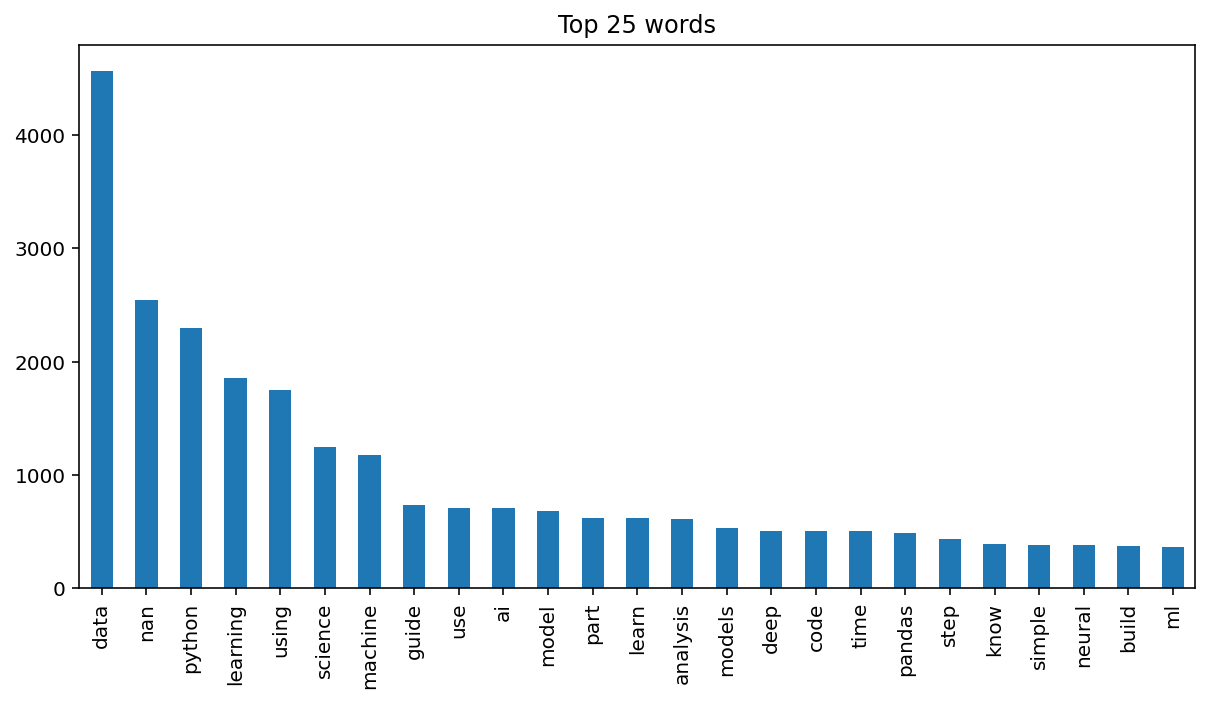

<IPython.core.display.Javascript object>

In [20]:
num_top_words = 25

top_words = hero.visualization.top_words(
    medium_df['clean']).head(num_top_words)
top_words.plot.bar(rot=90, title=f"Top {num_top_words} words")
plt.show()


#### Check for clusters of words

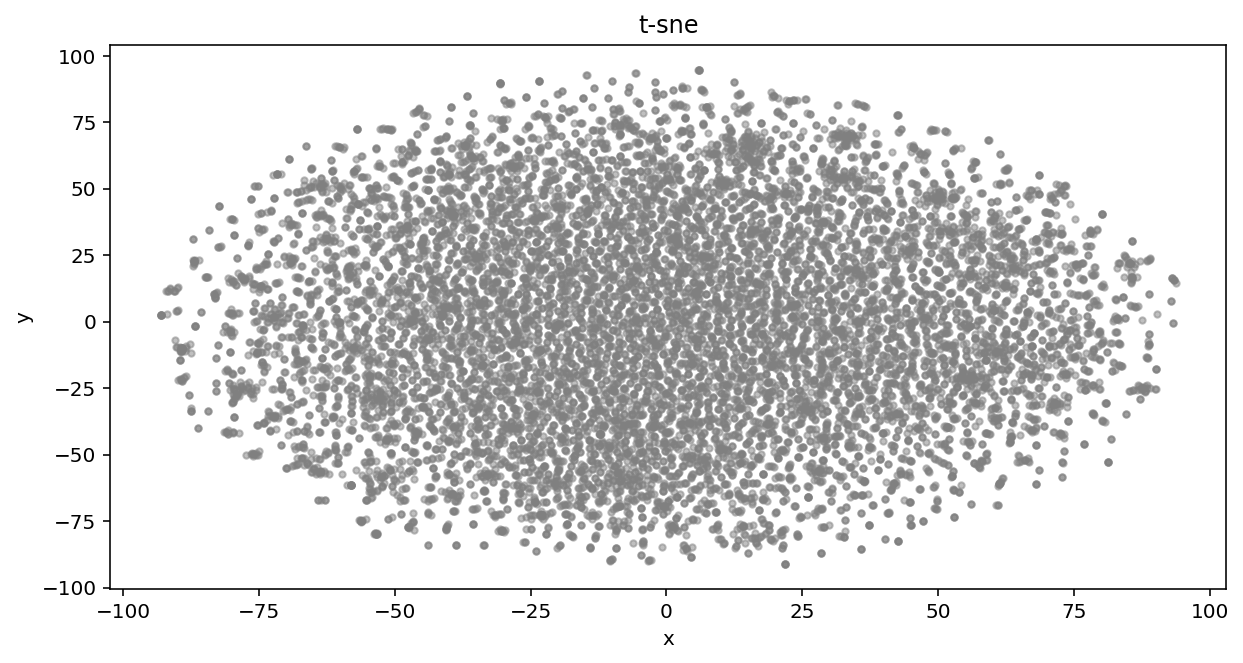

<IPython.core.display.Javascript object>

In [21]:
medium_df["tsne"] = medium_df["tfidf"].pipe(hero.tsne, n_components=2, random_state=42)
medium_df_tsne = pd.DataFrame(medium_df["tsne"].to_list(), columns=["x", "y"])
medium_df_tsne.plot(kind="scatter", x="x", y="y", alpha=0.5, s=10, c="grey")
plt.title("t-sne")
plt.show()

OBSERVATION: no apparent large clusters discovered - words in corpus are distributed in a fairly manner.

#### Non-negative matrix factorization of term frequencies

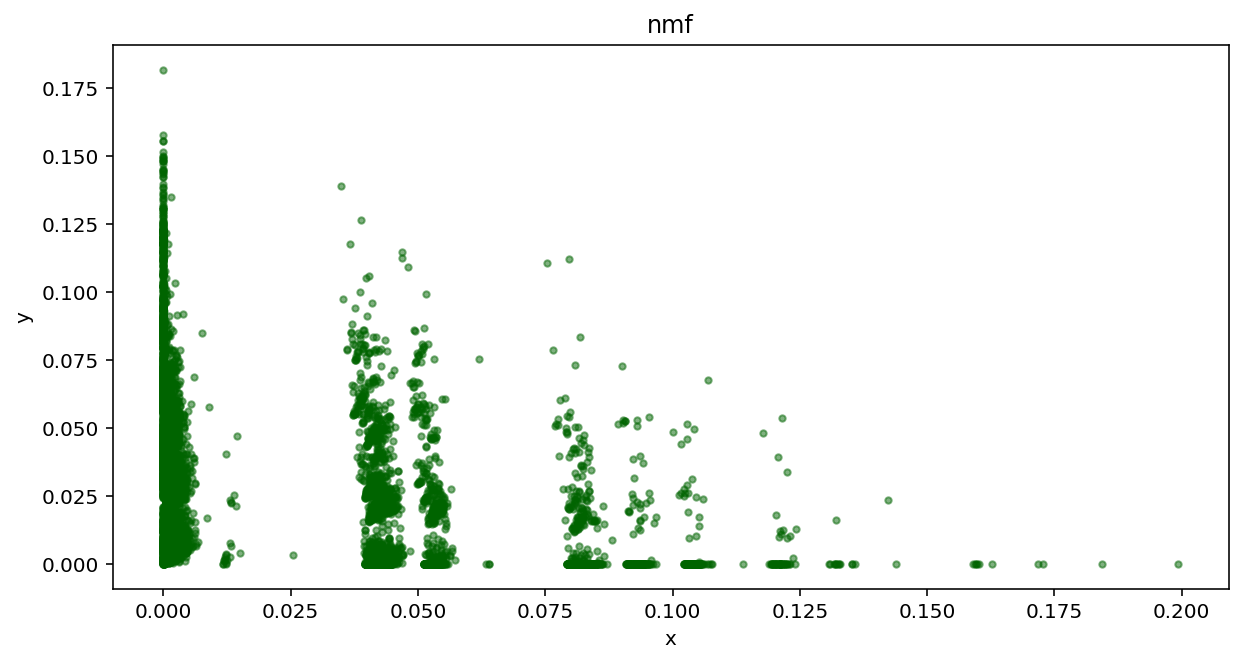

<IPython.core.display.Javascript object>

In [45]:
medium_df["term_f"] = medium_df["clean"].pipe(hero.term_frequency)
medium_df["nmf"] = hero.nmf(medium_df["term_f"], n_components=2)
medium_df_nmf = pd.DataFrame(medium_df["nmf"].to_list(), columns=["x", "y"])
medium_df_nmf.plot(kind="scatter", x="x", y="y", alpha=0.5, s=10, c="darkgreen")
plt.title("nmf")
plt.show()

OBSERVATION: about a dozen groups of words show up, but it is hard to say what is their composition

#### Get rid of unneeded columns

In [29]:
medium_df.drop(
    columns=[
        "id",
        "url",
        "author",
        "title",
        "subtitle",
        "publication",
        "pub_date",
        "desc",
        "tfidf",
        "tsne",
        "term_f",
        "nmf",
    ],
    inplace=True,
)

<IPython.core.display.Javascript object>

### Back to sklearn: train-test split

In [38]:
print(f"Number of articles: {medium_df.shape[0]}")

Number of articles: 12825


<IPython.core.display.Javascript object>

If you want to run experiments on full dataset, set "smaller_test" value to full size above.

In [39]:
medium_df["log_claps"] = np.log1p(medium_df["claps"])
medium_df["log_responses"] = np.log1p(medium_df["responses"])
smaller_test = 12825
x_train, x_test, y_train, y_test = train_test_split(
    medium_df[:smaller_test][["log_responses", "reading_time", "clean"]],
    medium_df[:smaller_test]["log_claps"],
    test_size=0.2,
    random_state=42,
)

<IPython.core.display.Javascript object>

### Experiment 1: TF-IDF feature

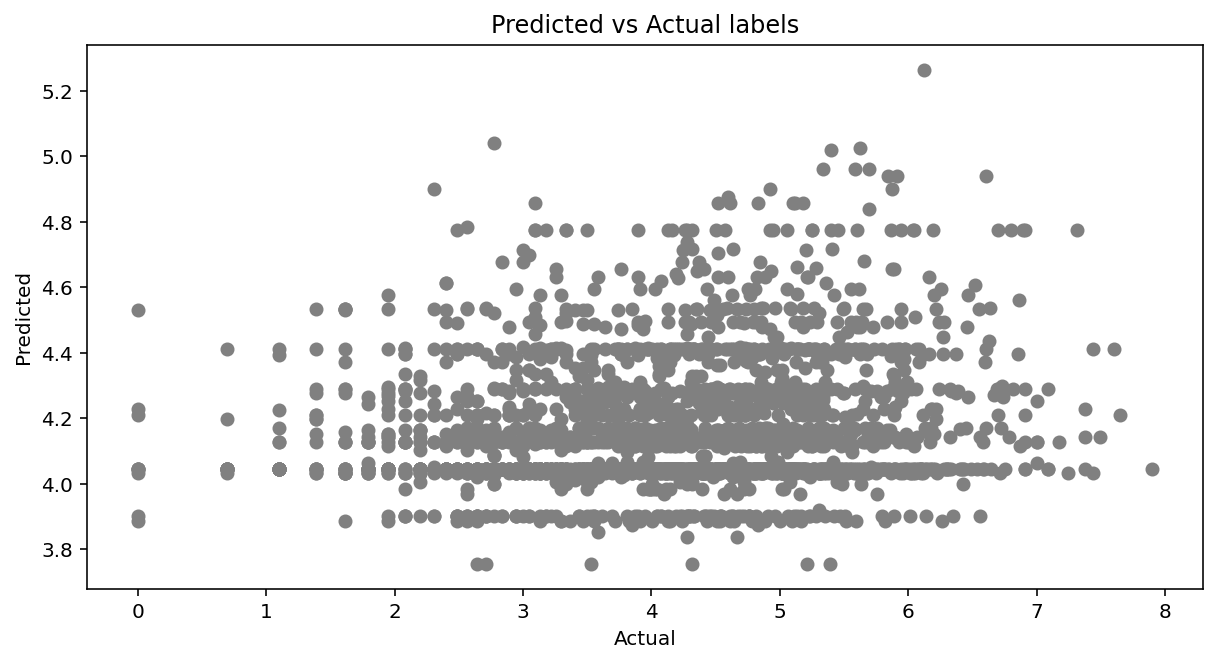

Predictions' metrics
RMSE:   1.52
MAE:    0.98
MAPE:   7193064396290405.0%


<IPython.core.display.Javascript object>

In [49]:
regressor = Ridge(alpha=1)

v = TfidfVectorizer(ngram_range=(1, 2), min_df=0.05, max_df=0.95, norm=None)
x_train_tf = v.fit_transform(x_train["clean"])
x_test_tf = v.transform(x_test["clean"])

regressor.fit(x_train_tf, y_train)
y_pred = regressor.predict(x_test_tf)

df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
regression_results(y_test, y_pred, color="grey")

OBSERVATION: **Catastrophic results!** TF-IDF on articles' titles and subtitles fails completely. Apparently, them being very short and rarely having enough specific words and bigrams voids their potential predictive power. It makes no sense to try any regression optimisation.

### Experiment 1: Non-NLP features only

##### Claps vs Responses

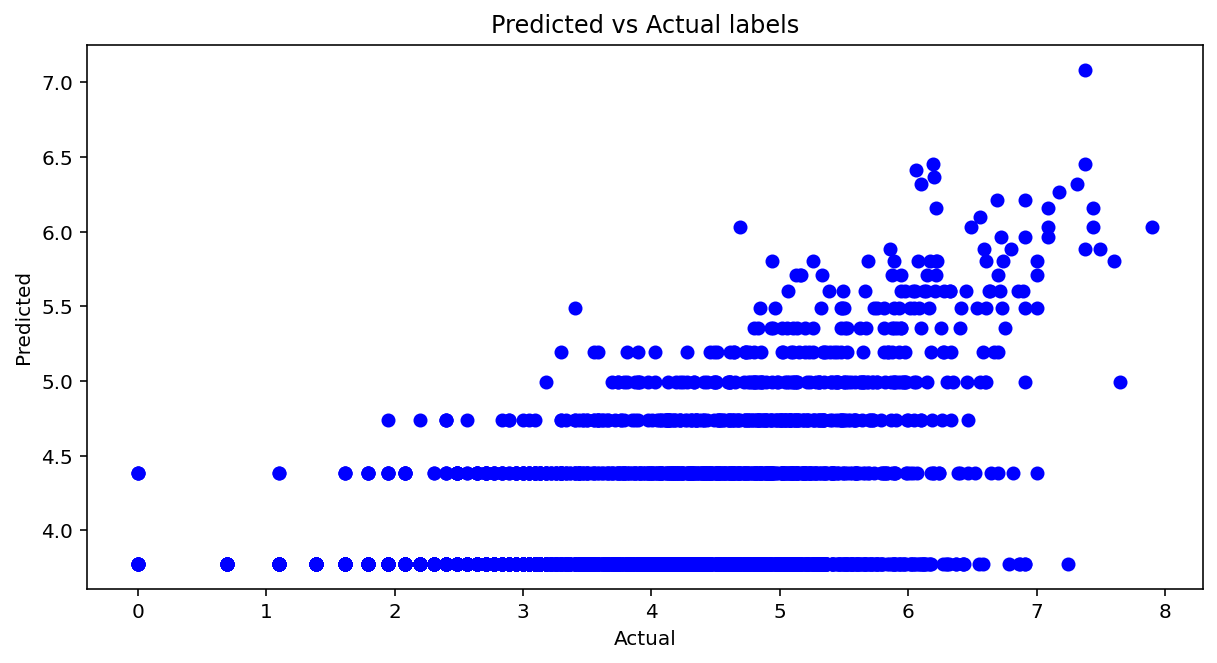

Predictions' metrics
RMSE:   1.24
MAE:    0.88
MAPE:   6949447030253067.0%


<IPython.core.display.Javascript object>

In [41]:
regressor = Ridge(alpha=1.0)

regressor.fit(x_train[["log_responses"]], y_train)  # , "reading_time"
y_pred = regressor.predict(x_test[["log_responses"]])  # , "reading_time"

df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
regression_results(y_test, y_pred, color="blue")

##### Claps vs Reading time

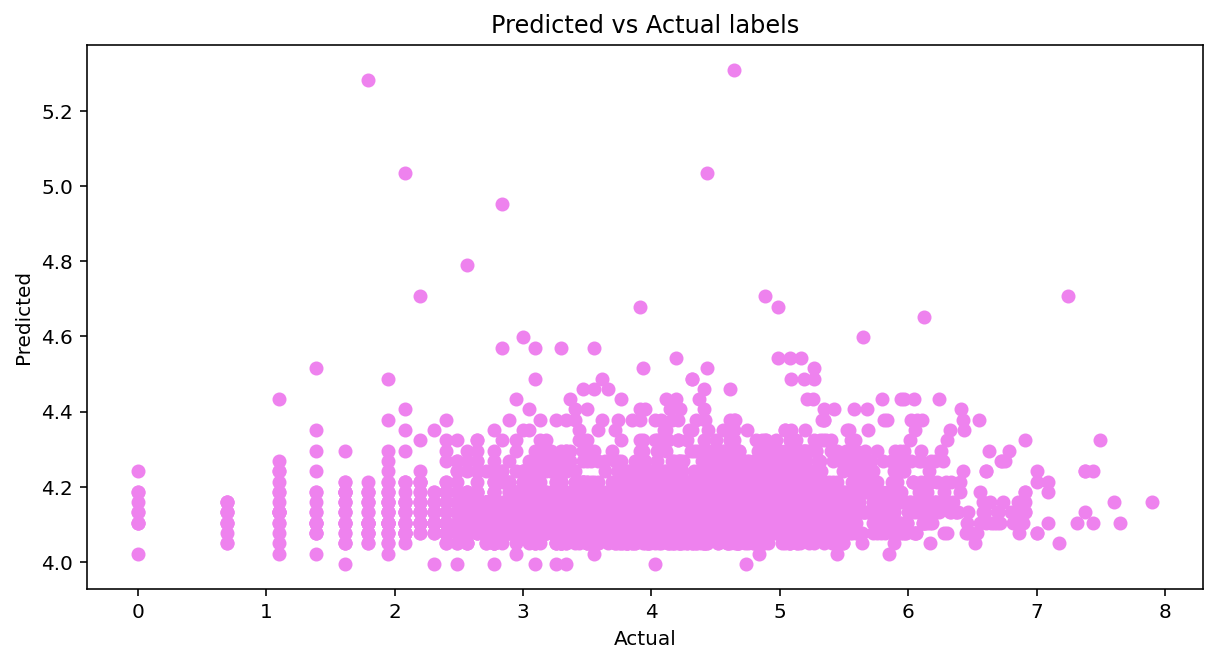

Predictions' metrics
RMSE:   1.54
MAE:    0.99
MAPE:   7263827450806794.0%


<IPython.core.display.Javascript object>

In [46]:
regressor = Ridge(alpha=1.0)

regressor.fit(x_train[["reading_time"]], y_train)  # ,
y_pred = regressor.predict(x_test[["reading_time"]])  # , "reading_time"

df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
regression_results(y_test, y_pred, color="violet")

OBSERVATION: Not much success with non-text features either, although "responses" regression gives an interesting result - predicted number of claps practically never exceeds the actual number.

### CONCLUSION

Results of this work show that readers of popular Medium publication "Towards data science" judge articles by their contents with no correlation to wording of article title. A question arises: is there any correlation with the text properties of body text in NLP sense?